<img src="https://raw.githubusercontent.com/Mauritas99/Proyect_images/refs/heads/main/Banners/Machine-learning-banner.jpg" width="100%">

><h2><em>Introducción</em><h2>

<h5 style="font-size:1.4rem;">En base a la corrección realizada al dataset original, se busca determinar en que medida las diferentes variables analizadas <b>(estado nutricional, socioeconómicas y ecológicas)</b> inciden en la aparición de enfermedades cardiovasculares en pacientes residentes en la provincia de Córdoba, que asisten al centro de cardiología del Hospital Nacional de Clínicas.</h5>
<h5 style="font-size:1.4rem;">Para ello, se confeccionó el índice <b>"Salud Cardiovascular Ideal"</b>, propuesto por la Asociación Americana del Corazón, donde se puede estimar dicho riesgo en base a 7 métricas (4 comportamientos saludables y 3 factores de salud ideales) y un puntaje final, que varia entre "Ideal", "Intermedio" y "Pobre".</h5>
<h5 style="font-size:1.4rem;">Con el dataset confeccionado, se <b>entrenará y evaluará</b> un modelo que se ajuste de mejor manera para predecir un valor de "SCI" y en que medida las diferentes variables <b>inciden</b> en dicha predicción.</b> </h5>

><h2><em>Preprocesamiento</em><h2>

<h4><em>1. Importar librerias</em></h4>
<hr>

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%run ../functions/functions.ipynb import binarizar_columnas

# Modelado y evaluación:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,roc_auc_score,classification_report,confusion_matrix, recall_score,roc_curve,accuracy_score
import xgboost

<h4><em>2. Cargar base de datos</em></h4>
<hr>

In [106]:
df = pd.read_csv("../1.1_data_limpia/base_pacientes_corregida.csv")

<h4><em>3. Codificar variables.</em></h4>
<hr>

<h4><em>3.1. Categóricas binomiales.</em></h4>
<hr width=80% style="position:relative; left:-10%;">

<p style="font-size:1.4rem;text-align:center;">Al existir solo 2 posibles resultados para nuestra variable a predecir, y debido al orden de importancia entre presentar o no un <b>SCI "Pobre"</b>, se va a mapear en sentido de presencia o ausencia de dicho valor de SCI.</p>

In [107]:
sci_map = {
    "Pobre" : 1,
    "Intermedio" : 0
}

df["SCI_Final_Cod"] = df["SCI_Final"].map(sci_map)
df = df.drop(columns=["SCI_Final"])

In [108]:
df['Sexo_fem'] = df['Sexo'].apply(lambda x: 1 if x == 1 else 0)
df['Sexo_masc'] = df['Sexo'].apply(lambda x: 1 if x == 0 else 0)
df = df.drop(columns="Sexo")

<h4><em>3.2. Categóricas nominales.</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [109]:
var_categ_nom = df.loc[:,["IMC_clasif","Localidad","Ocupacion","NDVI_clasif","NDWI_clasif","NDBI_clasif"	]]

ohe_encoder = OneHotEncoder()

var_categ_nom_encoded = ohe_encoder.fit_transform(var_categ_nom)

var_categ_nom_encoded_df = pd.DataFrame(data=var_categ_nom_encoded.toarray(),columns=ohe_encoder.get_feature_names_out())

df = pd.concat([df,var_categ_nom_encoded_df],axis=1)

df = df.drop(columns=var_categ_nom.columns)

<h4><em>3.3. Categóricas ordinales.</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [110]:
var_categ_ord = df.loc[:,["Grado de Inst.","AF_cod"]]

orden_grad_ins = ["Analfabeta","Primario incompleto","Primario completo","Secundario incompleto","Secundario completo","Terciario incompleto","Terciario completo","Universitario incompleto","Universitario completo"]
orden_af = ["Bajo","Moderado","Alto"]

ord_encoder_grad = OrdinalEncoder(categories=[orden_grad_ins])
orden_grad_encoded = ord_encoder_grad.fit_transform(var_categ_ord[["Grado de Inst."]])
var_categ_ord["Grado de Inst."] = orden_grad_encoded

ord_encoder_af = OrdinalEncoder(categories=[orden_af])
orden_af_encoded = ord_encoder_af.fit_transform(var_categ_ord[["AF_cod"]])
var_categ_ord["AF_cod"] = orden_af_encoded

df = df.drop(columns=["Grado de Inst.","AF_cod"])
df = pd.concat([df,var_categ_ord],axis=1)

<h4><em>4. Correlación entre variables y variable de interés</em></h4>
<hr>

In [111]:
matriz_corr = df.corr(numeric_only=True) # Matriz de correlación entre variables numericas.

print(f"Principales variables relacionadas positivamente con SCI_Final_Cod : \n\n{matriz_corr["SCI_Final_Cod"].sort_values(ascending=False).head(6).drop(index="SCI_Final_Cod")}")
print("\n")
print(f"Principales variables relacionadas negativamente con SCI_Final_Cod : \n\n{matriz_corr["SCI_Final_Cod"].sort_values(ascending=False).tail(5)}")

Principales variables relacionadas positivamente con SCI_Final_Cod : 

IMC_clasif_Obesidad    0.327897
IMC_kg/m2              0.294806
TBQ_cod                0.256552
PAS_mmhg               0.228323
PAD_mmhg               0.214245
Name: SCI_Final_Cod, dtype: float64


Principales variables relacionadas negativamente con SCI_Final_Cod : 

Consumo_verduras       -0.156389
IMC_clasif_Normopeso   -0.223952
Grado de Inst.         -0.247008
Ocupacion_Docente      -0.297544
AF_cod                 -0.299343
Name: SCI_Final_Cod, dtype: float64


<h4><em>5. Definir variables y grupos de entrenamiento y prueba</em></h4>
<hr>

<h4><em></em></h4>

In [112]:
X = df.drop(columns=["SCI_Final_Cod"]) # Variables predictoras.
y = df["SCI_Final_Cod"] # Variable a predecir.

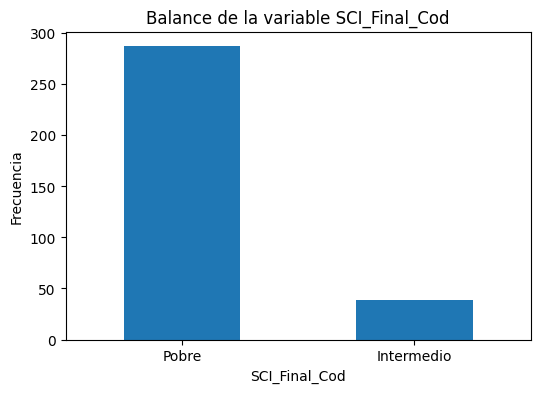

In [113]:
plt.figure(figsize=(6,4)) # Representar pesos dentro de la variable a predecir.
y.value_counts().plot(kind="bar")
plt.title("Balance de la variable SCI_Final_Cod")
plt.xticks(rotation=0,ticks=[0,1,],labels=["Pobre","Intermedio"])
plt.ylabel("Frecuencia")
plt.show()

<p>Existe una diferencia muy marcada entre las clases de la variable a predecir.</p>

In [114]:
# Aplicar SMOTE para balancear la clase minoritaria "Intermedio".

sm = SMOTE()
X_res,y_res = sm.fit_resample(X=X,y=y)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

<h4><em>6. Normalización de variables</em></h4>
<hr>

In [116]:
var_scal = ["Edad","IMC_kg/m2","PAS_mmhg","PAD_mmhg","Sodio mg/d","Glucemia_m","Col_mg/dl",'Bebidas_azucar ml/sem','Consumo_verduras', 'Consumo_pescado']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.loc[:,var_scal])
X_test_scaled = scaler.transform(X_test.loc[:,var_scal])

X_train_scaled_df = pd.DataFrame(data=X_train_scaled,columns=scaler.get_feature_names_out(),index=X_train.index)
X_test_scaled_df = pd.DataFrame(data=X_test_scaled,columns=scaler.get_feature_names_out(),index=X_test.index)

#Eliminar columnas numericas sin escalar.
X_train.drop(X_train.loc[:,var_scal], inplace=True,axis=1)
X_test.drop(X_test.loc[:,var_scal], inplace=True,axis=1)

#Agregar columnas numericas escaladas.
X_train = pd.concat([X_train,X_train_scaled_df],axis="columns")
X_test = pd.concat([X_test,X_test_scaled_df],axis="columns")

><h2><em>Instanciar modelos</em><h2>

<h4 ><em>1. Regresión logística</em></h4>
<hr>

In [117]:
logistic_model = LogisticRegression(penalty="l2")

logistic_model.fit(X_train,y_train) # Entrenamiento del modelo.

y_train_pred_log = logistic_model.predict(X_train) # Realizar predicción set de entrenamiento.
y_test_pred_log = logistic_model.predict(X_test) # Realizar predicción set de prueba.

<h4 ><em>1.1 Evaluación general del modelo</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [118]:
#Precisión.
precision_train = precision_score(y_train,y_train_pred_log)
precision_test = precision_score(y_test,y_test_pred_log)

# Sensibilidad.
recall_train = recall_score(y_train,y_train_pred_log) 
recall_test = recall_score(y_test,y_test_pred_log)


report_train = classification_report(y_train, y_train_pred_log)
report_test = classification_report(y_test, y_test_pred_log)

print(f"Entrenamiento:\n\n Precisión: {precision_train:.2f}\n Sensibilidad: {recall_train:.2f}\n Matriz de confusión:\n\n {report_train}")
print(f"Prueba:\n\n Precisión: {precision_test:.2f}\n Sensibilidad: {recall_test:.2f}\n Matriz de confusión:\n\n {report_test}")


Entrenamiento:

 Precisión: 0.99
 Sensibilidad: 0.93
 Matriz de confusión:

               precision    recall  f1-score   support

           0       0.93      0.99      0.96       231
           1       0.99      0.93      0.96       228

    accuracy                           0.96       459
   macro avg       0.96      0.96      0.96       459
weighted avg       0.96      0.96      0.96       459

Prueba:

 Precisión: 0.93
 Sensibilidad: 0.92
 Matriz de confusión:

               precision    recall  f1-score   support

           0       0.91      0.93      0.92        56
           1       0.93      0.92      0.92        59

    accuracy                           0.92       115
   macro avg       0.92      0.92      0.92       115
weighted avg       0.92      0.92      0.92       115



<h4 ><em>1.2 Curva ROC-AUC</em></h4>
<hr width=80% style="position:relative; left:-10%;">

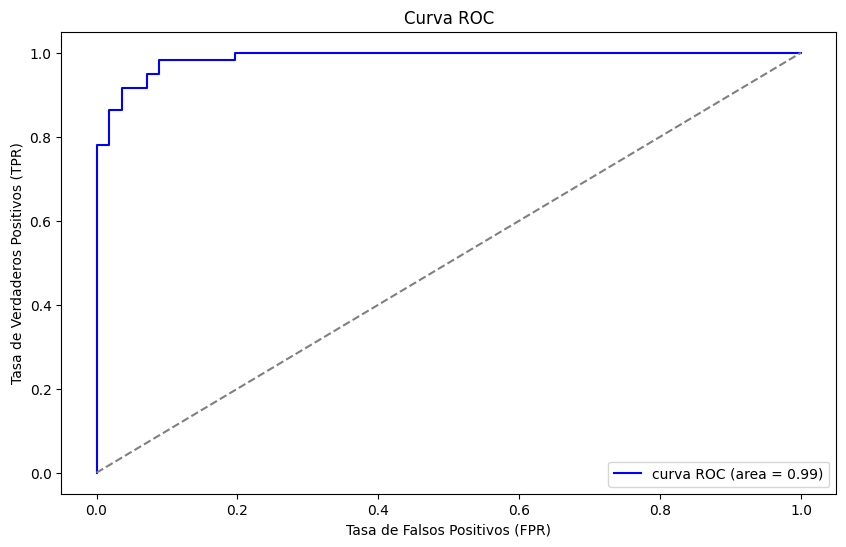

AUC para el conjunto de testeo: 0.99


In [119]:
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva.

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f'AUC para el conjunto de testeo: {roc_auc:.2f}')

<h4 ><em>1.3 Coeficiente de Correlación del modelo</em></h4>
<hr width=80% style="position:relative; left:-10%;">

<p>Indica la relación entre las variables independientes y la probabilidad de la clase 1 (SCI = "Pobre"). Al aumentar dicho valor de esa variable, tambien aumenta la probabilidad de que la prediccion de clase sea 1.</p>

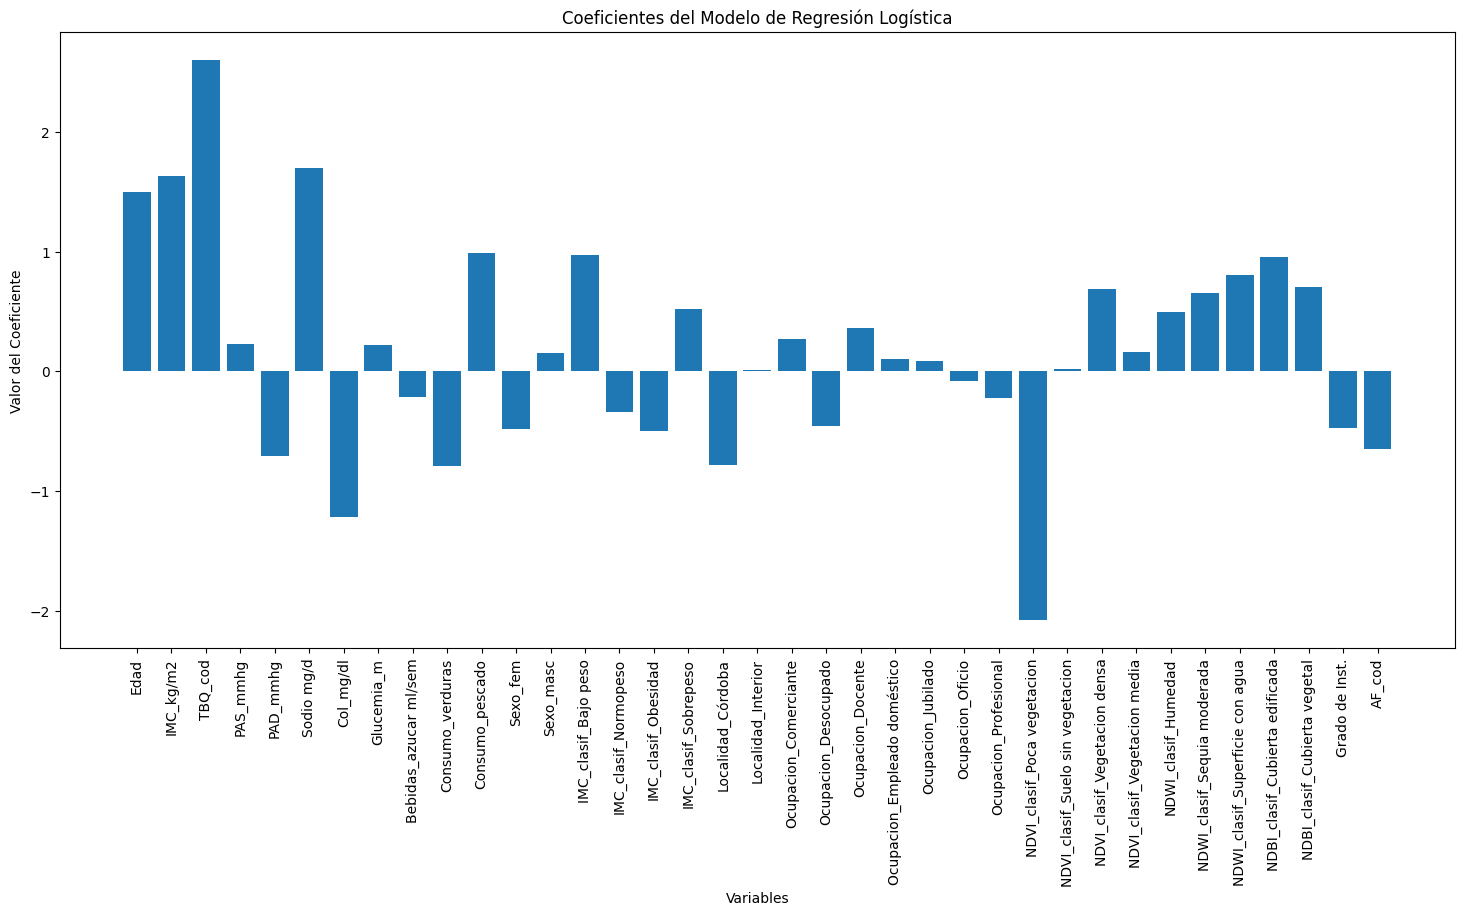

In [120]:

coef = logistic_model.coef_[0]
columnas = X.columns 
coef_df = pd.DataFrame(coef, index=columnas, columns=['Coeficiente'])


plt.figure(figsize=(18, 8))
plt.bar(coef_df.index, coef_df['Coeficiente'])
plt.title('Coeficientes del Modelo de Regresión Logística')
plt.ylabel('Valor del Coeficiente')
plt.xlabel('Variables')
plt.xticks(rotation=90)


plt.show()


<h4 ><em>2. XGBoost</em></h4>
<hr>

In [121]:
xgb = xgboost.XGBClassifier() # Empleamos un modelo de clasificacion binaria.

<h4 ><em>2.1 GridSearch CV</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [131]:
# Parametros de entrenamiento.
params = {
    "learning_rate" : [0.05,0.1],
    "n_estimators" : [100,200],
}

In [132]:
cv = GridSearchCV(estimator=xgb,param_grid=params,cv=3)
cv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimators': [100, 200]})

In [133]:
best_xgb = cv.best_estimator_ # Mejor modelo (n_estimators = 200 | learning_rate = 0.1).
y_pred_xgb = best_xgb.predict(X_test) # Realizando predicción con el mejor modelo.

In [141]:
# Comparar predicciones de los 2 modelos y los datos reales.
comp_df = pd.DataFrame({"Real" : y_test,"Test_reg_log" : y_test_pred_log,"Test_xgb" : y_pred_xgb})
comp_df.head(10)

,Real,Test_reg_log,Test_xgb
514,0,0,0
70,1,1,1
131,0,0,0
422,0,0,0
545,0,0,0
321,1,0,1
188,1,1,1
29,1,1,1
81,1,0,1
310,1,1,1


<h4 ><em>2.2 Evaluación general del modelo (Xgboost)</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [135]:
precision = precision_score(y_test,y_pred_xgb) # Útil para casos médicos (detección de enfermedad).
recall = recall_score(y_test,y_pred_xgb) # Sensibilidad.
reporte = classification_report(y_test, y_pred_xgb)

print(f"Métricas Xgboost:\n\n Precisión: {precision:.2f}\n Sensibilidad: {recall:.2f}\n Matriz de confusión:\n\n {reporte}")

Métricas Xgboost:

 Precisión: 0.98
 Sensibilidad: 1.00
 Matriz de confusión:

               precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.98      1.00      0.99        59

    accuracy                           0.99       115
   macro avg       0.99      0.99      0.99       115
weighted avg       0.99      0.99      0.99       115



<h4 ><em>2.3 Feature importance</em></h4>
<hr width=80% style="position:relative; left:-10%;">

In [142]:
importancias_df = pd.DataFrame({
    'Característica': X_train.columns, 
    'Importancia': best_xgb.feature_importances_
}).sort_values(by='Importancia', ascending=False)  # Ordenar por importancia de mayor a menor

importancias_df.head(10)

,Característica,Importancia
0,TBQ_cod,0.216961
28,IMC_kg/m2,0.198349
26,AF_cod,0.176624
29,PAS_mmhg,0.079949
25,Grado de Inst.,0.045577
16,NDVI_clasif_Poca vegetacion,0.040019
33,Col_mg/dl,0.037805
35,Consumo_verduras,0.024114
17,NDVI_clasif_Suelo sin vegetacion,0.023668
14,Ocupacion_Oficio,0.020291


<h4 style="top:2px;"><em>Resumen del proceso de instanciado de los modelos.</em></h4>
 <h5 style="font-size:1.7rem;">General:</h5>
    <ul>
        <li style="font-size:1.4rem; margin-top:-30px;">Se encontró un <b>marcado desbalance de clases</b> dentro de la variable objetivo, por lo que se implementó <b>SMOTE</b> para generar datos sintéticos para la clase minoritaria.
        </li>
        <li style="font-size:1.4rem; margin-top:10px;">Previamente al instanciado del modelo, se <b>pre-procesaron</b> las variables según su naturaleza (escalado y codificación).</b></li>
    </ul>
    <ol style="font-size:1.6rem;">
        <li><em>Regresión logística</em></li>
        <ul>
            <li style="font-size:1.3rem; margin-top:10px;">Se escogió este modelo de regresión al ser un problema de <b>clasificación binaria.</b></li>
            <li style="font-size:1.3rem; margin-top:10px;">La puntuación dentro de las métricas de evaluación arrojaron una <b>precisión</b> y <b>sensibilidad</b> general del modelo alta.</li>
            <li style="font-size:1.3rem; margin-top:10px;">La comparación de métricas de evaluación entre el set de entrenamiento y de prueba <b>no mostró diferencias significativas</b> en el rendimiento del modelo, a la hora de clasificar datos nuevos.</li>
            <li style="font-size:1.3rem; margin-top:10px;">El valor del area bajo la curva de ROC arrojo un valor cercano a 1, indicando su <b>alta tasa de aciertos</b> a la hora de clasificar el valor de SCI para cada paciente.</li>
            <li style="font-size:1.3rem; margin-top:10px;">El coeficiente de correlación del modelo arrojo que las variables "TBQ_cod", "IMC_kg/m2" y "Edad" empujan al efecto de la predicción (SCI == Pobre), a diferencia de "NDVI_clasif_Poca vegetacion" que da sentido a la predicción en dirección contraria (SCI == Intermediio)</li>
        </ul>
        <li><em>Xgboost Classifier</em></li>
        <ul>
            <li style="font-size:1.3rem; margin-top:10px;">A su vez, se entrenó un modelo Xgboost (específicamente XgboostClassifier), para comparar el rendimiento de ambos modelos.</li>
            <li style="font-size:1.3rem; margin-top:10px;">Se empleó GridsearchCV para obtener los mejores <b>hiperparámetros de entrenamiento</b>, y se escogio el modelo con la mejor configuración.</li>
            <li style="font-size:1.3rem; margin-top:10px;">Las métricas de evaluación arrojaron valores <b>elevados</b> sobre el rendimiento del modelo.</li>
            <li style="font-size:1.3rem; margin-top:10px;">Se creó un dataframe para comparar las salidas de <b>ambas predicciones.</b></li>
            <li style="font-size:1.3rem; margin-top:10px;">Dentro de las características mas importantes, feature_importace arrojo que "TBQ_cod", "IMC_kg/m2" y "AF_cod" fueron las variables mas influyentes a la hora de realizar las predicciones.</li>
        </ul>
    </ol>
    
    

><h2><em>Conclusión</em><h2>

<p>Se logró instanciar de manera eficiente dos modelos que pueden predecir, teniendo en cuenta las variables de interés, si un paciente de determinadas características posee o no un riesgo cardiovascular elevado o no.</p>
<p>Ambos modelos (regresión logística y xgboostClassifier) mostraron que las variables "TBQ_cod" e "IMC_kg/m2" fueron determinantes a la hora de empujar las predicciones.</p>
<p>No obstante, otras variables como las relacionadas al ambiente, o al grado de instrucción y ocupación tambien se encontraron asociadas a este suceso.</p>
<p>Poder implementar modelos predictivos para encontrar con antelación cuando determinados valores puedan sugerir un riesgo cardiovascular a futuro es, no solo una recomendación, sino una necesidad para la población y un compromiso para la salud pública.</p>